# WSensing 2021 - Classification of Denial of Service Attacks on Wi-Fi-based Unmanned Aerial Vehicle

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree, preprocessing, linear_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
import pydotplus

seed = 11

%matplotlib inline

---

In [2]:
df = pd.read_csv("dataset.csv.gz", header = 0)
df.head()

,Protocol,Bytes,TimeDelta,DestPort,SrcPort,Class
0,udp,106,0.000012,14550.0,14551.0,normal
1,udp,106,0.000011,14550.0,14551.0,normal
2,udp,106,0.000037,14550.0,14551.0,normal
3,udp,108,0.000036,14550.0,14551.0,normal
4,udp,106,0.000064,14550.0,14551.0,normal


In [3]:
df['Class'].value_counts()

normal      459839
deauth        8576
udpflood      5493
dostcp         403
Name: Class, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474311 entries, 0 to 474310
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Protocol   474311 non-null  object 
 1   Bytes      474311 non-null  int64  
 2   TimeDelta  474311 non-null  float64
 3   DestPort   179837 non-null  float64
 4   SrcPort    179837 non-null  float64
 5   Class      474311 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 21.7+ MB


In [5]:
df['Protocol'].value_counts()

tcp     213259
udp     179837
wlan     81215
Name: Protocol, dtype: int64

In [6]:
d = {'udp': 0, 'tcp': 1, 'wlan': 2}
df['Protocol'] = df['Protocol'].map(d)

d = {'normal': 0, 'deauth': 1, 'dostcp': 1, 'udpflood': 1}
df['Class'] = df['Class'].map(d)
df.head()

,Protocol,Bytes,TimeDelta,DestPort,SrcPort,Class
0,0,106,0.000012,14550.0,14551.0,0
1,0,106,0.000011,14550.0,14551.0,0
2,0,106,0.000037,14550.0,14551.0,0
3,0,108,0.000036,14550.0,14551.0,0
4,0,106,0.000064,14550.0,14551.0,0


## Applicable features for Learning Task
> Just `Bytes` and `TimeDelta`

In [7]:
df.columns[1:3]

Index(['Bytes', 'TimeDelta'], dtype='object')

In [8]:
features = list(df.columns[1:3])
df['TimeDelta'] = df['TimeDelta'].astype(np.float64)

### Classes

In [9]:
target_names = ['Normal', 'DoS']

## Stratified Train-test split

In [10]:
y = df["Class"]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.4, random_state=seed)

---
# Decision Tree

In [11]:
clf = tree.DecisionTreeClassifier(max_depth = 3, random_state=seed)
clf = clf.fit(X_train,y_train)

## Model Interpretability

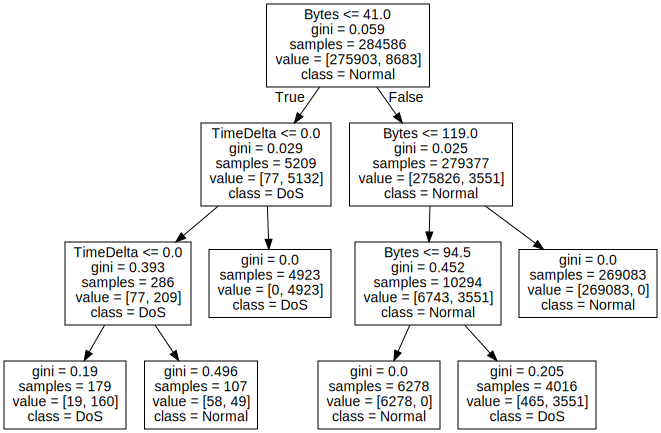

In [12]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=target_names,
                               )
# Draw graph
graph = graphviz.Source(dot_data, format="pdf") 
graph

In [13]:
out_graph = pydotplus.graph_from_dot_data(dot_data) 
out_graph.write_pdf('dt.pdf')

True

## Model Evaluation

In [14]:
print ("Tree Classifier Accuracy: ")
print (clf.score(X_test,y_test))
y_pred_dt = clf.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names=target_names))

Tree Classifier Accuracy: 
0.9979760179206747
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    183936
         DoS       0.94      0.99      0.97      5789

    accuracy                           1.00    189725
   macro avg       0.97      1.00      0.98    189725
weighted avg       1.00      1.00      1.00    189725



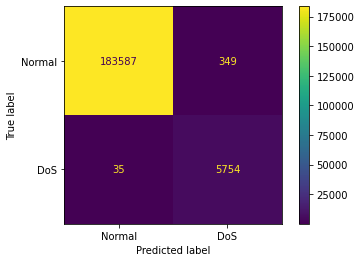

In [15]:
cm = confusion_matrix(y_test, y_pred_dt)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.show()

In [16]:
n = y_pred_dt.shape[0]
print(round(fp/n,3), round(fn/n,4))

0.002 0.0002


---
# Logistic Regression

In [17]:
LR = linear_model.LogisticRegression(random_state=seed)
LR.fit(X_train, y_train)

LogisticRegression(random_state=11)

## Model Interpretability

In [18]:
LR.coef_, LR.intercept_

(array([[ -0.07862087, -12.13391404]]), array([5.44717146]))

## Model Evaluation

In [19]:
print ("Logistic Regression Classifier Accuracy: ")
print (LR.score(X_test,y_test))

y_pred_lr = LR.predict(X_test)
print(classification_report(y_test, y_pred_lr,target_names=target_names))

Logistic Regression Classifier Accuracy: 
0.982010805112663
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    183936
         DoS       0.76      0.59      0.67      5789

    accuracy                           0.98    189725
   macro avg       0.88      0.79      0.83    189725
weighted avg       0.98      0.98      0.98    189725



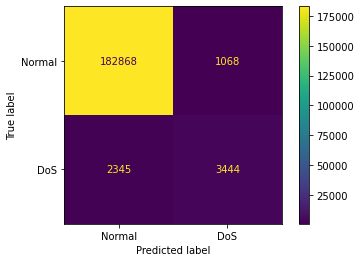

In [20]:
cm = confusion_matrix(y_test, y_pred_lr, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()
disp.plot()
plt.show()

In [21]:
n = y_pred_lr.shape[0]

In [22]:
print(round(fp_lr/n,3), round(fn_lr/n,3))

0.006 0.012


---
# Prediction Inference Latency
> This Inference Latency calculation is for all Test subset

In [23]:
%timeit LR.predict(X_test)

4.59 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit clf.predict(X_test)

6.75 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print("Total of {} samples infered.".format(X_test.shape[0]))

Total of 189725 samples infered.
